# Place Cell Analyses

Analyze TH data for place cells.

Cells of interest:
- No cells show clear / traditional place cell responses

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.spatial.information import compute_spatial_information_2d
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.utils import restrict_range, get_value_by_time_range
from spiketools.utils.trials import epoch_data_by_range, epoch_spikes_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing

In [5]:
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from spiketools.spatial.occupancy import compute_bin_time

## Settings

In [6]:
# Define the base data folder
data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH')

In [7]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [8]:
# Define bins to use
bins = [6, 10]

# Define minimum required occupancy (in seconds)
min_occ = 1

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'

# shuffle_approach = 'BINCIRC'
n_surrogates = 1000

In [10]:
# Set example unit to analyze
uind = 36

## Load Data

In [11]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [12]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Extract Time Definitions

In [13]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Extract Position Data

In [14]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [15]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-10, 10])

#### Extract Boundaries

In [16]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]
print('X boundary range: ', x_boundary)
print('Z boundary range: ', z_boundary)

X boundary range:  [349.8549 419.8549]
Z boundary range:  [298.     419.3358]


#### Select position traces from navigation periods

In [17]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

In [18]:
# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

#### Extract Spike Data

In [19]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [20]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Position Data

In [21]:
# Compute position ranges
x_range, z_range = get_pos_ranges(positions)

In [22]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Z-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*z_range, z_range[1] - z_range[0]))

Position X-range:  365.40 - 404.59 (39.18)
Position Z-range:  302.87 - 411.54 (108.67)


In [23]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions, threshold=0.1)
spike_positions = np.array([spike_xs, spike_ys])

In [24]:
# Check binning
x_bin_edges, y_bin_edges = compute_spatial_bin_edges(positions, bins, area_range)

In [25]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(get_bin_width(x_bin_edges), get_bin_width(y_bin_edges)))

Bin widths: 11.67, 12.13


### Occupancy

In [26]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, speed, minimum=min_occ,
                        area_range=area_range, set_nan=True)

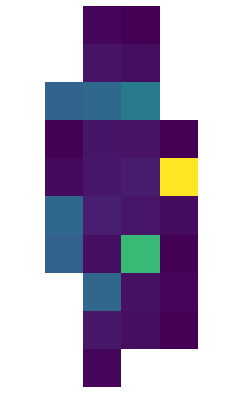

In [27]:
# Plot occupancy
plot_heatmap(occ, transpose=True, ignore_zero=False, figsize=(5, 7))

## Check spike locations

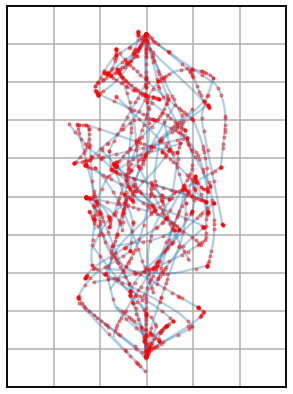

In [28]:
# Plot the map across all position traces (plotted per trial)
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               xlim=list(x_boundary), ylim=list(z_boundary),
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [29]:
# Compute spatial bin assignments for each spike
x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [30]:
# Compute summary map of bin firing
bin_firing = compute_bin_firing(x_binl, y_binl, bins)

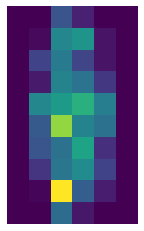

In [31]:
# Check the firing map
plot_heatmap(bin_firing, transpose=True)

In [32]:
# Normalize bin firing by occupancy
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
normed_bin_firing = bin_firing / occ

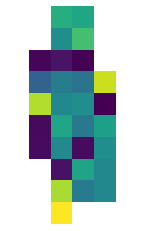

In [33]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing, transpose=True)

## Place coding per trial

In [34]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

# Set a trial index to get data for
t_ind = 5

Number of trials: 24


In [35]:
# Get the navigation time ranges
nav_starts_trial = nwbfile.trials.navigation_start[t_ind]
nav_stops_trial = nwbfile.trials.navigation_stop[t_ind]

In [36]:
# Get data for selected trial: trial positions, spikes, and spike positions
trial_times, trial_pos = get_value_by_time_range(ptimes, positions,
                                                 nav_starts_trial, nav_stops_trial)
trial_spikes = restrict_range(spikes, nav_starts_trial, nav_stops_trial)
trial_spike_pos_x, trial_spike_pos_y = get_spike_positions(trial_spikes, trial_times, trial_pos)
spike_positions_trial = np.array([trial_spike_pos_x, trial_spike_pos_y])

In [37]:
# Compute spatial bin assignments for each spike
x_binl_trial, y_binl_trial = compute_spatial_bin_assignment(spike_positions_trial, x_bin_edges, y_bin_edges)

In [38]:
# Compute summary map of bin firing for one selected trial
bin_firing_trial = (compute_bin_firing(x_binl_trial, y_binl_trial, bins)).flatten()

# ANOVA TEST

### Use fr ~ C(bin),  real data

In [39]:
# get firing rate per bin, per trial
bin_firing_trial = np.zeros([n_trials, 60])
bin_firing_trial_norm = np.zeros([n_trials, 60])

for ind in range(n_trials):
    nav_starts_trial = nwbfile.trials.navigation_start[ind]
    nav_stops_trial = nwbfile.trials.navigation_stop[ind]
    
    # Get data for selected trial: trial positions, spikes, and spike positions
    trial_times, trial_pos = get_value_by_time_range(ptimes, positions,
                                                     nav_starts_trial, nav_stops_trial)
    trial_spikes = restrict_range(spikes, nav_starts_trial, nav_stops_trial)
    trial_speed = restrict_range(speed, nav_starts_trial, nav_stops_trial)
    trial_spike_pos_x, trial_spike_pos_y = get_spike_positions(trial_spikes, trial_times, trial_pos)
    spike_positions_trial = np.array([trial_spike_pos_x, trial_spike_pos_y])
    
    # Compute spatial bin assignments for each spike
    x_binl_trial, y_binl_trial = compute_spatial_bin_assignment(spike_positions_trial, x_bin_edges, y_bin_edges)
    
    # Compute occupancy
    tocc = compute_occupancy(trial_pos, trial_times, bins, trial_speed, minimum=min_occ,
                             area_range=area_range, set_nan=True)

    # Compute summary map of bin firing for one selected trial
    bin_firing_trial[ind,:] = (compute_bin_firing(x_binl_trial, y_binl_trial, bins)).flatten()
    bin_firing_trial_norm[ind,:] = bin_firing_trial[ind,:] / tocc.flatten()

In [40]:
# create bin labels
bin_firing_trial=bin_firing_trial.flatten()
bin_firing_trial_norm = bin_firing_trial_norm.flatten()

bin_label = np.array(range(0, 60))
bin_label = np.tile(bin_label,n_trials)

In [41]:
# create dataframe for ANOVA
merged_array = np.transpose(np.vstack([bin_label,bin_firing_trial_norm]))
df = pd.DataFrame(merged_array,columns=['bin', 'fr'] )
df = df.dropna()

df.head(10)

,bin,fr
17,17.0,1.850699
18,18.0,2.077551
28,28.0,9.402745
37,37.0,3.047990
43,43.0,1.605128
85,25.0,3.334705
88,28.0,4.382097
89,29.0,4.273482
107,47.0,2.489613
134,14.0,3.000984


In [42]:
# build the ANOVA model
model = smf.ols('fr ~ C(bin)', data=df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)
model.summary()

              sum_sq    df         F    PR(>F)
C(bin)    147.161735  30.0  1.385519  0.132088
Residual  251.373512  71.0       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.386
Date:                Wed, 20 Apr 2022   Prob (F-statistic):              0.132
Time:                        17:00:23   Log-Likelihood:                -190.73
No. Observations:                 102   AIC:                             443.5
Df Residuals:                      71   BIC:                             524.8
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8652      1.086      2.637      0.010       0.699       5.031
C(bin)[T.13.0]    -1.5419      1.718     -0.898      0.372      -4.967       1.883
C(bin)[T.14.0]     0.8011      1.437      0.557      0.579      -2.064       3.667
C(bin)[T.15.0]     1.8637      1.536      1.213      0.229      -1.200       4.927
C(bin)[T.16.0]     0.2827      1.536      0.184      0.855      -2.781       3.346
C(bin)[T.17.0]    -0.1207      1.718     -0.070      0.944      -3.546       3.304
C(bin)[T.18.0]    -0.7877      2.173     -0.363      0.718      -5.120       3.545
C(bin)[T.20.0]     1.2238      2.173      0.563      0.575      -3.108       5.556
C(bin)[T.21.0]     1.6293      1.374      1.186      0.240      -1.111       4.369
C(bin)[T.22.0]    -1.1666      1.274     -0.916      0.363      -3.707       1.373
C(bin)[T.23.0]     0.7779      1.718      0.453      0.652      -2.647       4.203
C(bin)[T.24.0]     2.8961      1.536      1.885      0.064      -0.167       5.959
C(bin)[T.25.0]     0.0710      1.274      0.056      0.956      -2.469       2.611
C(bin)[T.26.0]     2.0319      2.173      0.935      0.353      -2.300       6.364
C(bin)[T.27.0]     1.7058      1.374      1.241      0.219      -1.034       4.446
C(bin)[T.28.0]     2.7336      1.437      1.902      0.061      -0.132       5.599
C(bin)[T.29.0]     1.4083      2.173      0.648      0.519      -2.924       5.741
C(bin)[T.31.0]     0.4177      1.437      0.291      0.772      -2.448       3.283
C(bin)[T.32.0]    -1.5738      1.718     -0.916      0.363      -4.999       1.851
C(bin)[T.33.0]    -0.9437      1.718     -0.549      0.584      -4.369       2.481
C(bin)[T.34.0]    -0.7949      1.298     -0.612      0.542      -3.384       1.794
C(bin)[T.35.0]     2.1411      1.536      1.394      0.168      -0.922       5.204
C(bin)[T.36.0]    -0.1528      1.374     -0.111      0.912      -2.893       2.587
C(bin)[T.37.0]    -0.2907      1.331     -0.219      0.828      -2.944       2.362
C(bin)[T.38.0]     1.8181      1.718      1.058      0.293      -1.607       5.243
C(bin)[T.41.0]    -1.0039      2.173     -0.462      0.645      -5.336       3.328
C(bin)[T.43.0]    -0.6675      1.718     -0.389      0.699      -4.092       2.757
C(bin)[T.44.0]     0.3919      1.374      0.285      0.776      -2.348       3.132
C(bin)[T.45.0]     0.4132      1.536      0.269      0.789      -2.650       3.477
C(bin)[T.47.0]    -0.9359      1.536     -0.609      0.544      -3.999       2.127
C(bin)[T.48.0]     0.1043      2.173      0.048      0.962      -4.228       4.437
==============================================================================
Omnibus:                       26.801   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.627
Skew:                   

In [43]:
# get the f-value from ANOVA model
f_val = aov_table['F']['C(bin)']
f_val

1.3855189826347418

# ANOVA Surrogate

### fr ~ C(bin), 100 surrogates

In [44]:
# get firing rate per bin, per trial, for shuffled data

times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates,shuffle_min=20000) #circular_shuffle
# times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates) #bin_circ
surrogates = []
for i, j in enumerate (times_shuffle):
    bin_firing_trial = np.zeros([n_trials,60])
    bin_firing_trial_norm = np.zeros([n_trials,60])
    for ind in range(n_trials):
        nav_starts_trial = nwbfile.trials.navigation_start[ind]
        nav_stops_trial = nwbfile.trials.navigation_stop[ind]

        # Get data for selected trial: trial positions, spikes, and spike positions
        trial_times, trial_pos = get_value_by_time_range(ptimes, positions,
                                                         nav_starts_trial, nav_stops_trial)
        trial_spikes = restrict_range(times_shuffle[i], nav_starts_trial, nav_stops_trial)
        trial_speed = restrict_range(speed, nav_starts_trial, nav_stops_trial)
        trial_spike_pos_x, trial_spike_pos_y = get_spike_positions(trial_spikes, trial_times, trial_pos)
        spike_positions_trial = np.array([trial_spike_pos_x, trial_spike_pos_y])

        # Compute spatial bin assignments for each spike
        x_binl_trial, y_binl_trial = compute_spatial_bin_assignment(spike_positions_trial, x_bin_edges, y_bin_edges)

        # Compute occupancy
        tocc = compute_occupancy(trial_pos, trial_times, bins, trial_speed, minimum=min_occ,
                                 area_range=area_range, set_nan=True)

        # Compute summary map of bin firing for one selected trial
        bin_firing_trial[ind,:] = (compute_bin_firing(x_binl_trial, y_binl_trial, bins)).flatten()
        bin_firing_trial_norm[ind,:] = bin_firing_trial[ind,:] / tocc.flatten()

    bin_firing_trial=bin_firing_trial.flatten()

    bin_firing_trial_norm = bin_firing_trial_norm.flatten()
    bin_label = np.array(range(0, 60))
    bin_label = np.tile(bin_label,n_trials)

    merged_array = np.transpose(np.vstack([bin_label,bin_firing_trial_norm]))
    df = pd.DataFrame(merged_array,columns=['bin', 'fr'] )
    df = df.dropna()

    model = smf.ols('fr ~ C(bin)', data=df).fit()
    aov_table = anova_lm(model, typ=2)
    f_val_surrs = aov_table['F']['C(bin)']

    surrogates.append(f_val_surrs)


In [45]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     3.197
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           3.11e-05
Time:                        17:00:36   Log-Likelihood:                -170.14
No. Observations:                 102   AIC:                             402.3
Df Residuals:                      71   BIC:                             483.6
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.7247      0.888      4.196      0.000       1.955       5.495
C(bin)[T.13.0]    -1.2533      1.404     -0.893      0.375      -4.052       1.545
C(bin)[T.14.0]    -0.0284      1.174     -0.024      0.981      -2.370       2.313
C(bin)[T.15.0]     1.3569      1.255      1.081      0.283      -1.146       3.860
C(bin)[T.16.0]    -1.9644      1.255     -1.565      0.122      -4.468       0.539
C(bin)[T.17.0]    -1.2175      1.404     -0.867      0.389      -4.016       1.581
C(bin)[T.18.0]    -1.6471      1.775     -0.928      0.357      -5.187       1.893
C(bin)[T.20.0]     3.9990      1.775      2.252      0.027       0.459       7.539
C(bin)[T.21.0]     1.3523      1.123      1.204      0.232      -0.887       3.591
C(bin)[T.22.0]    -1.8022      1.041     -1.731      0.088      -3.878       0.273
C(bin)[T.23.0]    -1.7811      1.404     -1.269      0.209      -4.580       1.018
C(bin)[T.24.0]     2.4641      1.255      1.963      0.054      -0.039       4.967
C(bin)[T.25.0]    -1.7096      1.041     -1.642      0.105      -3.785       0.366
C(bin)[T.26.0]     3.1313      1.775      1.764      0.082      -0.409       6.671
C(bin)[T.27.0]     1.6967      1.123      1.511      0.135      -0.542       3.936
C(bin)[T.28.0]    -0.6798      1.174     -0.579      0.564      -3.021       1.662
C(bin)[T.29.0]     1.3258      1.775      0.747      0.458      -2.214       4.866
C(bin)[T.31.0]     0.6745      1.174      0.574      0.568      -1.667       3.016
C(bin)[T.32.0]    -2.5231      1.404     -1.798      0.076      -5.322       0.276
C(bin)[T.33.0]    -1.5260      1.404     -1.087      0.281      -4.325       1.273
C(bin)[T.34.0]    -1.2678      1.061     -1.195      0.236      -3.383       0.848
C(bin)[T.35.0]     2.0119      1.255      1.603      0.113      -0.491       4.515
C(bin)[T.36.0]    -1.1668      1.123     -1.039      0.302      -3.406       1.072
C(bin)[T.37.0]    -1.8316      1.087     -1.685      0.096      -3.999       0.336
C(bin)[T.38.0]    -2.2009      1.404     -1.568      0.121      -5.000       0.598
C(bin)[T.41.0]    -1.1654      1.775     -0.656      0.514      -4.705       2.375
C(bin)[T.43.0]    -2.9735      1.404     -2.118      0.038      -5.772      -0.175
C(bin)[T.44.0]    -0.9392      1.123     -0.836      0.406      -3.178       1.300
C(bin)[T.45.0]    -0.5762      1.255     -0.459      0.648      -3.079       1.927
C(bin)[T.47.0]    -1.1174      1.255     -0.890      0.376      -3.621       1.386
C(bin)[T.48.0]    -0.7551      1.775     -0.425      0.672      -4.295       2.785
==============================================================================
Omnibus:                        6.791   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                8.064
Skew:                   

p-value: 0.97
z-score: -1.62


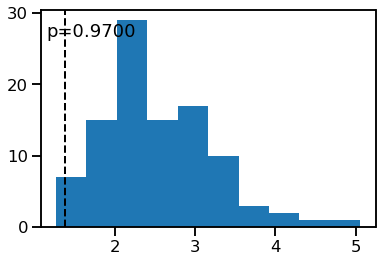

In [46]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(f_val, surrogates)

# Compute z-score of the real F-value compared to surrogates
z_score = zscore_to_surrogates(f_val, surrogates)

# Print out the compute p-value and z-scored information
print('p-value: {:4.2f}'.format(surr_p_val))
print('z-score: {:4.2f}'.format(z_score))

# Plot the distribution of surrogates, comparing to real F-value
plot_surrogates(surrogates, f_val, surr_p_val)

## All Cells

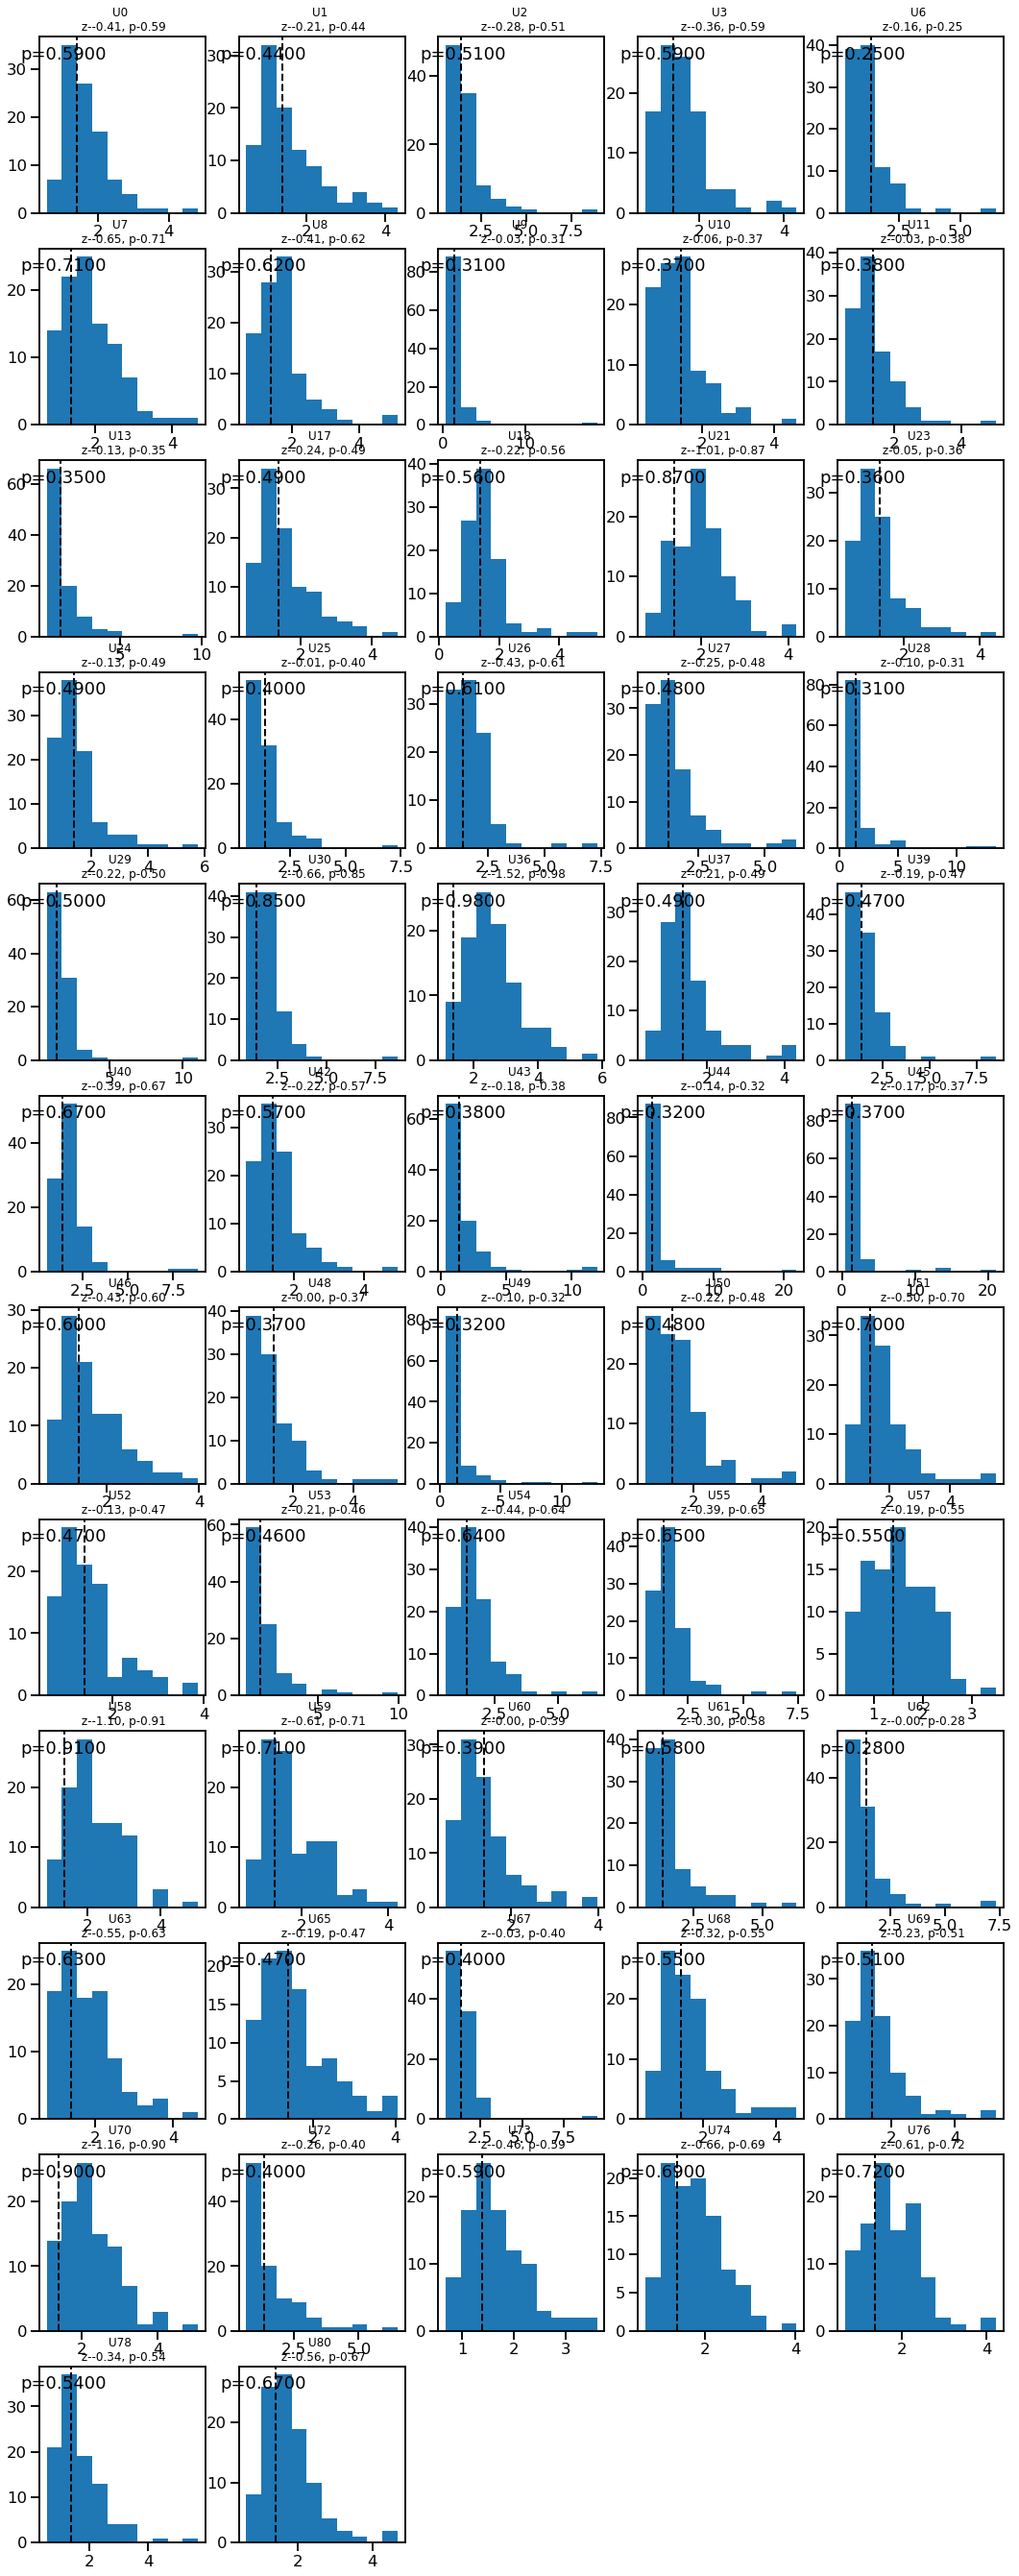

In [47]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates,shuffle_min=2000)
    
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)
    surrogates = []
    for i, j in enumerate (times_shuffle):
        bin_firing_trial = np.zeros([n_trials, 60])
        bin_firing_trial_norm = np.zeros([n_trials, 60])
        for ind in range(n_trials):
            nav_starts_trial = nwbfile.trials.navigation_start[ind]
            nav_stops_trial = nwbfile.trials.navigation_stop[ind]

            # Get data for selected trial: trial positions, spikes, and spike positions
            trial_times, trial_pos = get_value_by_time_range(ptimes, positions,
                                                             nav_starts_trial, nav_stops_trial)
            trial_spikes = restrict_range(times_shuffle[i], nav_starts_trial, nav_stops_trial)
            trial_speed = restrict_range(speed, nav_starts_trial, nav_stops_trial)
            trial_spike_pos_x, trial_spike_pos_y = get_spike_positions(trial_spikes, trial_times, trial_pos)
            spike_positions_trial = np.array([trial_spike_pos_x, trial_spike_pos_y])

            # Compute spatial bin assignments for each spike
            x_binl_trial, y_binl_trial = compute_spatial_bin_assignment(spike_positions_trial, x_bin_edges, y_bin_edges)

            # Compute occupancy
            tocc = compute_occupancy(trial_pos, trial_times, bins, trial_speed, minimum=min_occ,
                                     area_range=area_range, set_nan=True)

            # Compute summary map of bin firing for one selected trial
            bin_firing_trial[ind,:] = (compute_bin_firing(x_binl_trial, y_binl_trial, bins)).flatten()
            bin_firing_trial_norm[ind,:] = bin_firing_trial[ind,:] / tocc.flatten()
            
        bin_firing_trial=bin_firing_trial.flatten()
        bin_firing_trial_norm_1d = bin_firing_trial_norm.flatten()
        
        bin_label = np.array(range(0, 60))
        bin_label = np.tile(bin_label,n_trials)

        merged_array = np.transpose(np.vstack([bin_label,bin_firing_trial_norm_1d]))
        df = pd.DataFrame(merged_array,columns=['bin', 'fr'] )
        df = df.dropna()

        model = smf.ols('fr ~ C(bin)', data=df).fit()
        aov_table = anova_lm(model)
        f_val_surrs = aov_table['F']['C(bin)']

        surrogates.append(f_val_surrs)
        
    # Compute the empirical p-value based on surrogates
    surr_p_val = compute_empirical_pvalue(f_val, surrogates)

    # Compute z-score of the real F-value compared to surrogates
    z_score = zscore_to_surrogates(f_val, surrogates)

    # Plot the distribution of surrogates, comparing to real F-value
    plot_surrogates(surrogates, f_val, surr_p_val, ax=ax)
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, surr_p_val)
    ax.set_title(title, fontdict={'fontsize' : 12}, color=color)

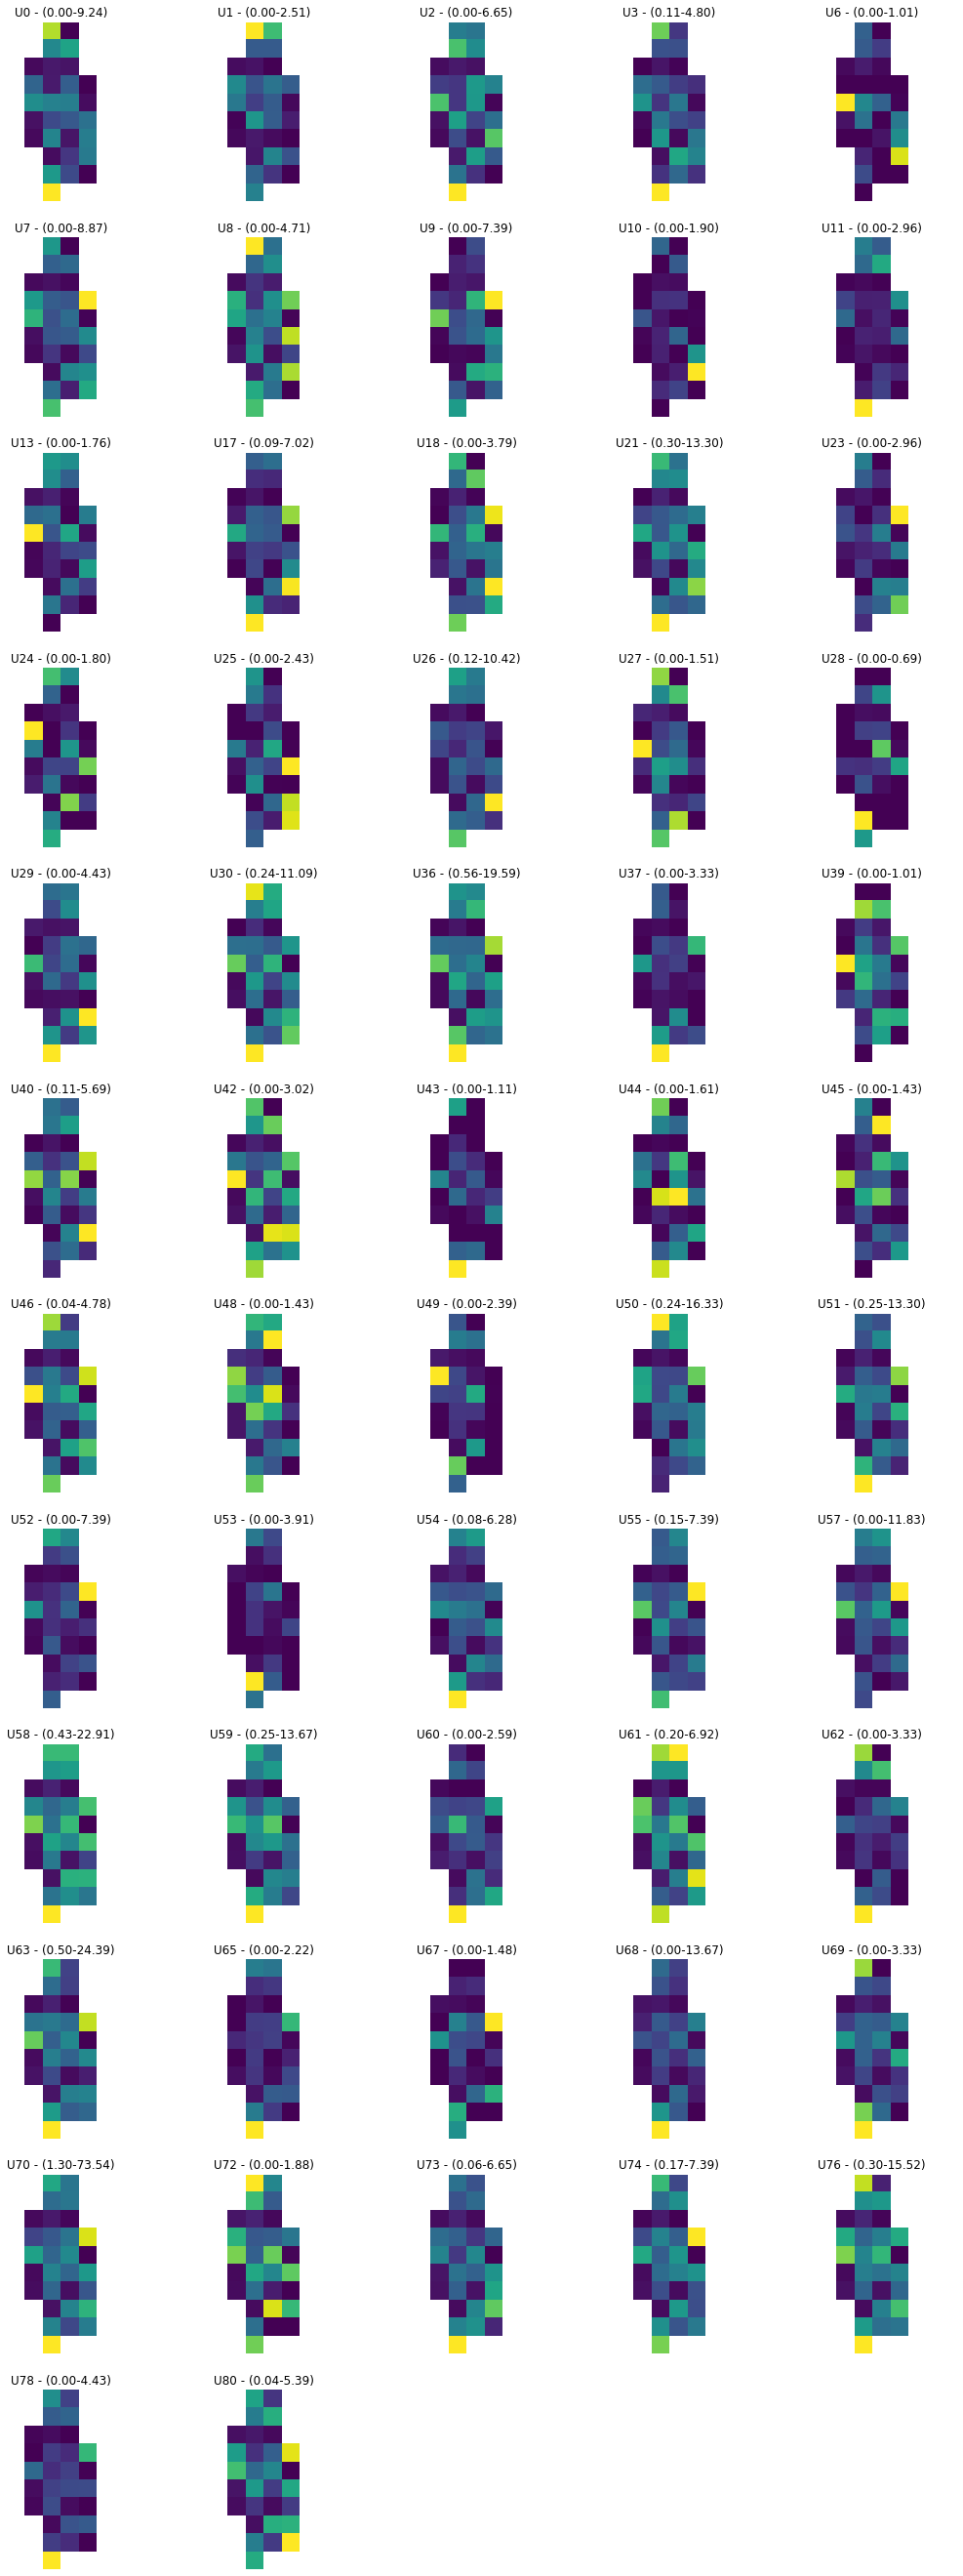

In [48]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
    spike_positions = np.array([spike_xs, spike_ys])
    
    # Compute spatial bin assignments for each spike, and compute normalized bin firing
    x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)
    bin_firing = compute_bin_firing(x_binl, y_binl, bins)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        normed_bin_firing = bin_firing / occ

    # Plot occupancy-normalized spatial firing
    plot_heatmap(normed_bin_firing, transpose=True, ax=ax)
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} - ({:1.2f}-{:1.2f})'.format(\
        ii, np.nanmin(normed_bin_firing), np.nanmax(normed_bin_firing))
    ax.set_title(title, fontdict={'fontsize' : 12})